## **IMPORTING NECESSARY MODULES**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## **DATA PREPARATION AND PREPROCESSING**

in order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain.

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # remove colour
    gray = cv2.GaussianBlur(gray, (5, 5), 0) # add Blur

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2) # shrink image
    thresh = cv2.dilate(thresh, None, iterations=2) # enlarge image

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1) # n, m , p
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

# **For better understanding let's take an example for our Dataset**

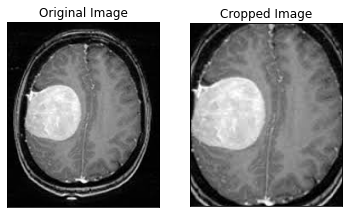

In [ ]:
ex_img = cv2.imread('Brain_tumor_detection/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# **Load up the Data:**
  The next function takes two arguments, the first one is a list of  directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to X and its label to y.

After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes': #/content/Brain_tumor_detection/augmented data/yes
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_path = 'Brain_tumor_detection/augmented data/'


augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


# **Defining function for Ploting sample images**

In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)] # list of images with lable [0 , 1 ] respecitvely
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n) # row calculation

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

# Plot Sample images

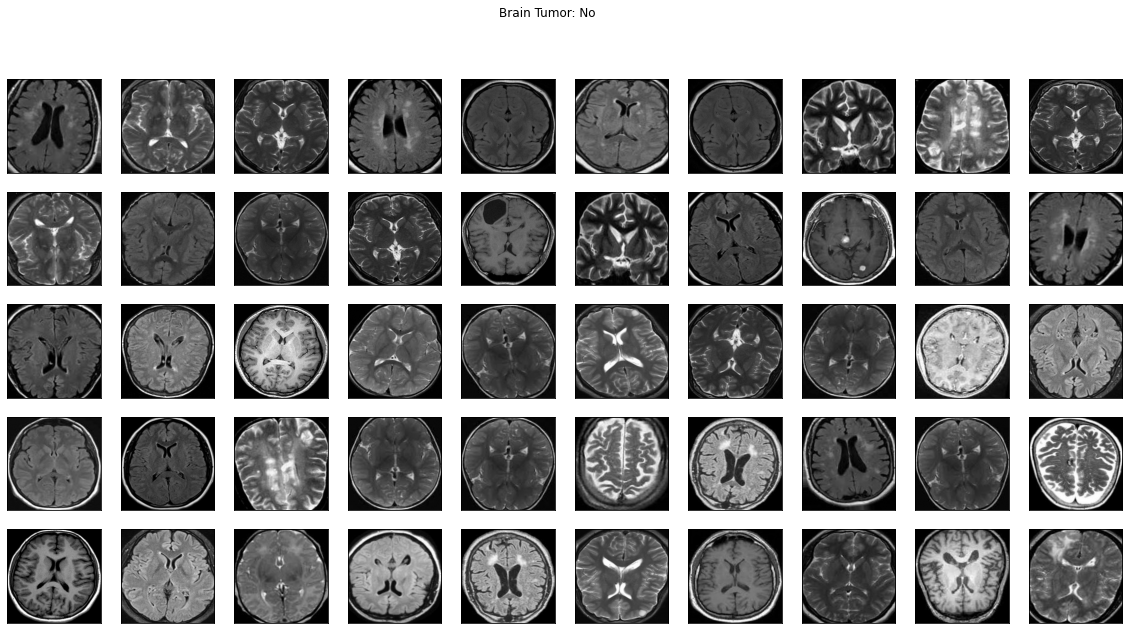

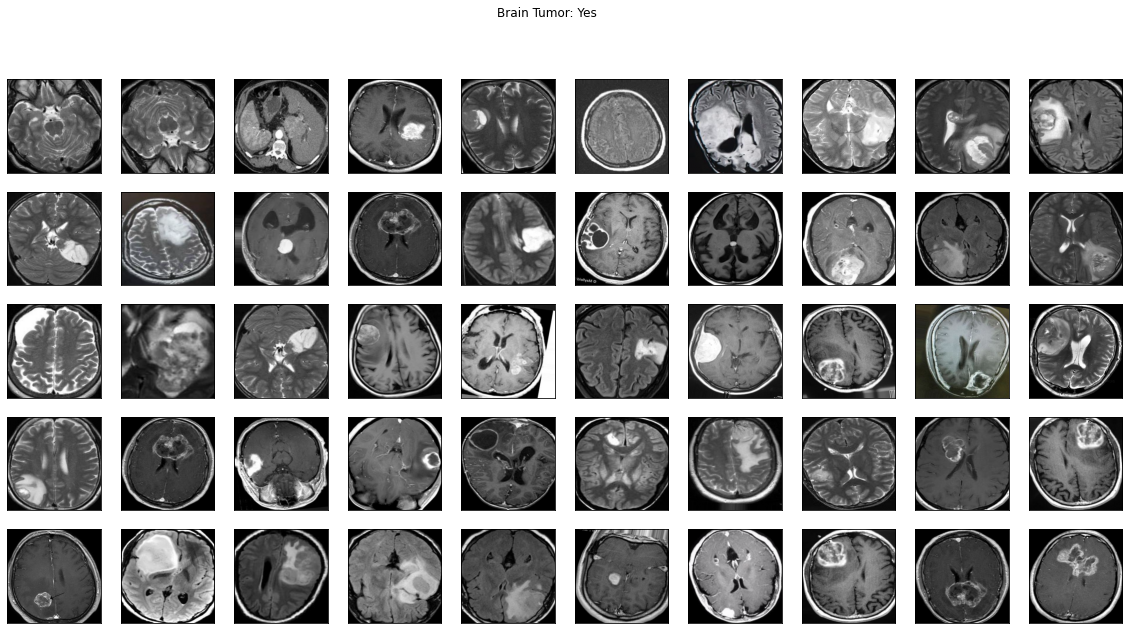

In [ ]:
plot_sample_images(X, y)

# **Splitting the Data**

Split X and y into training, validation (development) and validation sets



In [ ]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

*Let's use the following way to split:*

*1. 70% of the data for training.*

*2. 15% of the data for validation.*

*3. 15% of the data for testing.*

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


# **#Some Helper Function**

In [ ]:
#timer function for calculating time taken by epochs
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):  #  2* (precison *recall) / (precision+recall)
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# ***# Building a Model***

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL01
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Defining the image shape

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

**Compile the Model**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("Brain_tumor_detection/models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

# ***Training the Model***

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 144s 3s/step - loss: 0.7375 - accuracy: 0.6561 - val_loss: 0.6422 - val_accuracy: 0.6194
Epoch 2/10
46/46 [==============================] - 133s 3s/step - loss: 0.4529 - accuracy: 0.7834 - val_loss: 0.6059 - val_accuracy: 0.7645
Epoch 3/10
46/46 [==============================] - 132s 3s/step - loss: 0.3844 - accuracy: 0.8298 - val_loss: 0.5439 - val_accuracy: 0.8258
Epoch 4/10
46/46 [==============================] - 131s 3s/step - loss: 0.3528 - accuracy: 0.8464 - val_loss: 0.5080 - val_accuracy: 0.7968
Epoch 5/10
46/46 [==============================] - 132s 3s/step - loss: 0.3054 - accuracy: 0.8720 - val_loss: 0.4770 - val_accuracy: 0.8000
Epoch 6/10
46/46 [==============================] - 128s 3s/step - loss: 0.2723 - accuracy: 0.8983 - val_loss: 0.4371 - val_accuracy: 0.8258
Epoch 7/10
46/46 [==============================] - 131s 3s/step - loss: 0.2601 - accuracy: 0.8865 - val_loss: 1.1041 - val_accuracy: 0.5129
Epoch 8/10
46


**Train for some more epochs**

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 131s 3s/step - loss: 0.1725 - accuracy: 0.9343 - val_loss: 0.6563 - val_accuracy: 0.6935
Epoch 2/3
46/46 [==============================] - 131s 3s/step - loss: 0.1964 - accuracy: 0.9301 - val_loss: 1.2410 - val_accuracy: 0.5839
Epoch 3/3
46/46 [==============================] - 131s 3s/step - loss: 0.1776 - accuracy: 0.9315 - val_loss: 0.3727 - val_accuracy: 0.8516
Elapsed time: 0:7:23.2


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 131s 3s/step - loss: 0.1709 - accuracy: 0.9315 - val_loss: 0.6525 - val_accuracy: 0.8065
Epoch 2/3
46/46 [==============================] - 127s 3s/step - loss: 0.1346 - accuracy: 0.9522 - val_loss: 0.4194 - val_accuracy: 0.8516
Epoch 3/3
46/46 [==============================] - 127s 3s/step - loss: 0.1163 - accuracy: 0.9612 - val_loss: 0.3921 - val_accuracy: 0.8613
Elapsed time: 0:7:22.7


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 132s 3s/step - loss: 0.1027 - accuracy: 0.9702 - val_loss: 0.3618 - val_accuracy: 0.8548
Epoch 2/3
46/46 [==============================] - 127s 3s/step - loss: 0.0992 - accuracy: 0.9709 - val_loss: 1.0212 - val_accuracy: 0.7097
Epoch 3/3
46/46 [==============================] - 128s 3s/step - loss: 0.1592 - accuracy: 0.9308 - val_loss: 0.7640 - val_accuracy: 0.7290
Elapsed time: 0:6:27.0


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 131s 3s/step - loss: 0.1012 - accuracy: 0.9633 - val_loss: 0.4032 - val_accuracy: 0.8581
Epoch 2/5
46/46 [==============================] - 129s 3s/step - loss: 0.0789 - accuracy: 0.9820 - val_loss: 0.5194 - val_accuracy: 0.8000
Epoch 3/5
46/46 [==============================] - 128s 3s/step - loss: 0.0756 - accuracy: 0.9792 - val_loss: 0.6775 - val_accuracy: 0.7452
Epoch 4/5
46/46 [==============================] - 128s 3s/step - loss: 0.0640 - accuracy: 0.9855 - val_loss: 0.3410 - val_accuracy: 0.8677
Epoch 5/5
46/46 [==============================] - 128s 3s/step - loss: 0.0971 - accuracy: 0.9633 - val_loss: 0.8067 - val_accuracy: 0.7129
Elapsed time: 0:11:22.4


In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


# ***Plot Loss and Accuracy***

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
   
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

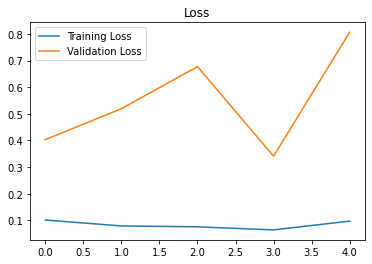

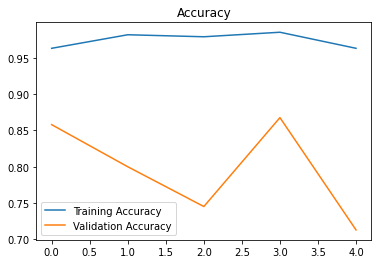

In [ ]:
plot_metrics(history) 


# **Results**
Let's experiment with the best model (the one with the best validation accuracy):





## **Load the Best Model**

In [ ]:
best_model = load_model(filepath='Brain_tumor_detection/models/cnn-parameters-improvement-10-0.86.model')

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 12s 1s/step - loss: 0.4109 - accuracy: 0.8419


#**Accuracy of the best model on the testing data:** 

In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.4109230041503906
Test Accuracy = 0.8419354557991028


In [ ]:
y_test_prob = best_model.predict(X_test)

In [ ]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8444444444444444


In [ ]:
y_val_prob = best_model.predict(X_val)

In [ ]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8746355685131196



# Result interpretation
Let's remember the percentage of positive and negative examples:


In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 


In [ ]:

data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.8719723183391%, number of pos examples: 764
Percentage of negative examples: 47.1280276816609%, number of neg examples: 681
Validation Data:
Number of examples: 310
Percentage of positive examples: 54.83870967741935%, number of pos examples: 170
Percentage of negative examples: 45.16129032258065%, number of neg examples: 140
Testing Data:
Number of examples: 310
Percentage of positive examples: 48.70967741935484%, number of pos examples: 151
Percentage of negative examples: 51.29032258064516%, number of neg examples: 159


# **Conclusion:**

**Now, the model detects brain tumor with:**

  **84%** accuracy on the **test set.**

  **0.87 f1** score on the **test set.**

  These resutls are very good considering that the data is balanced.


**Performance Table:** 

```
              Validation Set         Test Set

-----------------------------------------------
Accuracy                 96%              84%

F1 Score                0.84             0.87
```



